# pyGAM

[pyGAM](https://pygam.readthedocs.io/en/latest/index.html) is an API using `Generalized Additive Models` (GAMs) to model regression and classification problems. In this notebook, we will attempt to use pyGAM to model growth curves.

## Data

The growth curve is often described as `s-shaped` or `sigmoidal` in nature. One way to generate growth curve is my mixing Gaussian distributions. After you mix Gaussians, you can then estimate both the probability (PDF) and cummulative density functions (CDF). The CDF is precisely the growth curve or sigmoidal that we want to predict. In this example, we mix the following two Gaussians.

- $\mathcal{N}(10, 1)$
- $\mathcal{N}(3.7, 2)$

In [1]:
import numpy as np
import pandas as pd
import random
import bisect
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

plt.style.use('ggplot')
np.random.seed(37)
random.seed(37)

def mix(gaussians, n_samples=1_000, sample_delta=5, max_time=5):
    def sample(items):
        first = np.array([items[0]])
        mid = items[np.arange(1, len(items), sample_delta)]
        last = np.array([items[-1]])
        
        sample = np.concatenate([first, mid, last])
        return sample
        
    s = pd.concat([pd.Series(g.rvs(size=n_samples)) for g in gaussians]).reset_index(drop=True)
    c = (s.value_counts().sort_index() / len(s)).cumsum()
    
    i = MinMaxScaler((0, max_time)).fit_transform(c.index.values.reshape(-1, 1)).reshape(1, -1)[0]
    i = sample(i)
    v = sample(c.values)
    n = pd.Series(v, index=i, dtype=np.float64)
    
    return s, c, n

s, c, n = mix([norm(loc=10, scale=1), norm(loc=3.7, scale=2)])

These are the PDF and CDF plots. The shifted CDF plot shifts the CDF to the right so the domain is non-negative. The shifted CDF represents growth curves as time is usually on the x-axis and the start time is at zero.

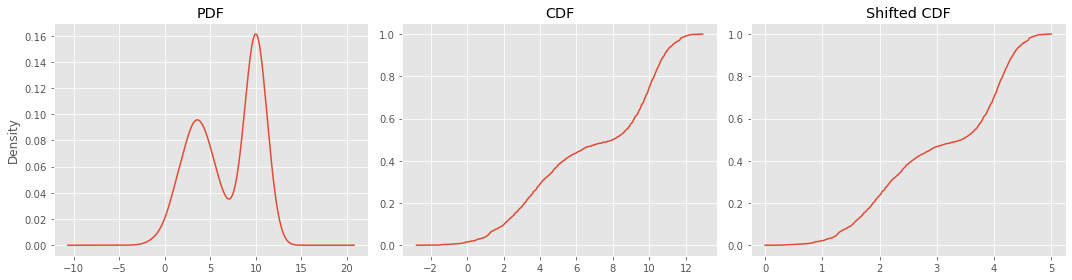

In [2]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

_ = s.plot(kind='kde', ax=ax[0], title='PDF')
_ = c.plot(kind='line', ax=ax[1], title='CDF')
_ = n.plot(kind='line', ax=ax[2], title='Shifted CDF')

plt.tight_layout()

## Learning

We will use the shifted CDF as our training data. Note that the samples are dependent, but the technique still works to model the growth curve.

In [3]:
y = n.values
X = n.index.values.reshape(-1, 1)

X.shape, y.shape

((402, 1), (402,))

In [4]:
from pygam import LinearGAM, s, f

gam = LinearGAM(s(0, n_splines=30)).fit(X, y)

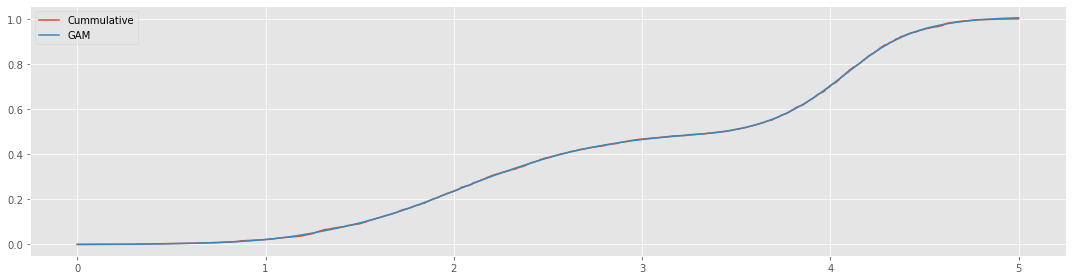

In [5]:
y_pred = gam.predict(X)

fig, ax = plt.subplots(figsize=(15, 4))

_ = n.plot(kind='line', ax=ax, label='Cummulative')
_ = pd.Series(y_pred, X.reshape(1, -1)[0]).plot(kind='line', ax=ax, label='GAM')

_ = ax.legend()

plt.tight_layout()

Here's an attempt to mix two growth curves. The first growth curve is a Gaussian mixture of the following densities.

- $\mathcal{N}(10, 1)$
- $\mathcal{N}(3.7, 2)$

The second growth curve is a Gaussian mixture of the following densities. Also, it is compressed to the domain $[0, 4]$.

- $\mathcal{N}(10, 1)$
- $\mathcal{N}(14, 2)$
- $\mathcal{N}(3.5, 1.5)$

In [6]:
s1, c1, n1 = mix([norm(loc=10, scale=1), norm(loc=3.7, scale=2)], max_time=5)
s2, c2, n2 = mix([norm(loc=10, scale=1), norm(loc=14, scale=2), norm(loc=3.5, scale=1.5)], max_time=4)

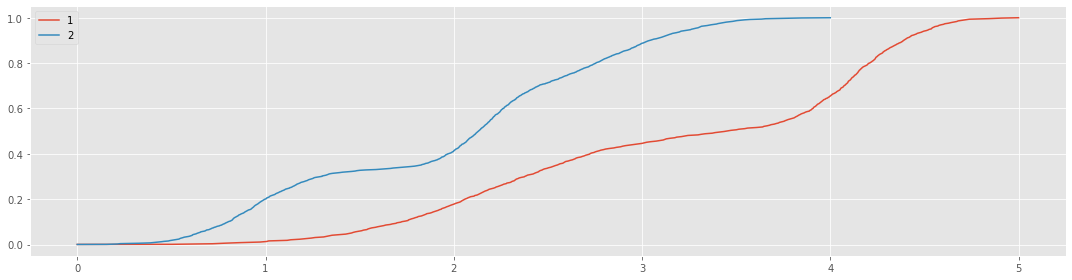

In [7]:
fig, ax = plt.subplots(figsize=(15, 4))

_ = n1.plot(kind='line', ax=ax, label='1')
_ = n2.plot(kind='line', ax=ax, label='2')

_ = ax.legend()

plt.tight_layout()

Just for fun, we can model a single curve from these two shifted CDF curves.

In [8]:
y = np.concatenate([n1.values, n2.values])
X = np.concatenate([n1.index.values, n2.index.values]).reshape(-1, 1)

X.shape, y.shape

((1004, 1), (1004,))

In [9]:
from pygam import LinearGAM, s, f

gam = LinearGAM(s(0, n_splines=30, constraints='monotonic_inc')).fit(X, y)

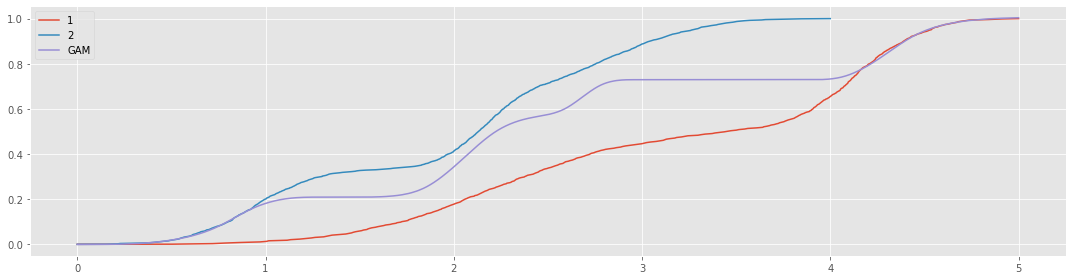

In [10]:
X = pd.Series(X.reshape(1, -1)[0]).sort_values().values.reshape(-1, 1)
y_pred = gam.predict(X)

fig, ax = plt.subplots(figsize=(15, 4))

_ = n1.plot(kind='line', ax=ax, label='1')
_ = n2.plot(kind='line', ax=ax, label='2')
_ = pd.Series(y_pred, X.reshape(1, -1)[0]).plot(kind='line', ax=ax, label='GAM')

_ = ax.legend()

plt.tight_layout()